#LOAD AND LABEL DATA

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# we are basically connecting drive to colab called mounting

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# -------- LOAD MERGED DATA --------
path_merged = "/content/drive/MyDrive/SWaT dataset/merged.csv"
df = pd.read_csv(path_merged)
df.columns = df.columns.str.strip()

# -------- LABEL ENCODING --------
y = df['Normal/Attack'].map({'Normal': 0, 'Attack': 1}).values

# -------- FEATURES --------
X = df.drop(columns=['Timestamp', 'Normal/Attack'])

# -------- SANITY CHECK --------
print("Label distribution:")
print(pd.Series(y).value_counts())


Label distribution:
0    1387098
1      54621
Name: count, dtype: int64


In [5]:
# -------- SPLIT NORMAL DATA FOR TRAINING --------
X_normal = X[y == 0]

MAX_NORMAL_SAMPLES = 120_000
X_normal = X_normal.iloc[:MAX_NORMAL_SAMPLES]

# -------- SCALING (fit ONLY on normal) --------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_normal)

# -------- CREATE MIXED TEST SET (balanced sampling) --------
MAX_TEST_SAMPLES = 200_000

# get indices of both classes
normal_indices = np.where(y == 0)[0]
attack_indices = np.where(y == 1)[0]

# sample proportionally
n_attack = min(len(attack_indices), MAX_TEST_SAMPLES // 4)
n_normal = MAX_TEST_SAMPLES - n_attack

selected_indices = np.concatenate([
    normal_indices[:n_normal],
    attack_indices[:n_attack]
])

X_test = scaler.transform(X.iloc[selected_indices])
y_limited = y[selected_indices]



In [6]:
def create_windows(data, window_size):
    n_samples = len(data) - window_size
    windows = np.zeros((n_samples, window_size, data.shape[1]), dtype=np.float32)
    for i in range(n_samples):
        windows[i] = data[i:i + window_size]
    return windows

WINDOW_SIZE = 20

# -------- CREATE WINDOWS --------
X_train_windows = create_windows(X_train, WINDOW_SIZE)
X_test_windows = create_windows(X_test, WINDOW_SIZE)

# -------- ALIGN LABELS --------
y_windowed = y_limited[WINDOW_SIZE:]

print("Train windows:", X_train_windows.shape)
print("Test windows:", X_test_windows.shape)
print("Normal in test:", (y_windowed == 0).sum())
print("Attack in test:", (y_windowed == 1).sum())



Train windows: (119980, 20, 51)
Test windows: (199980, 20, 51)
Normal in test: 149980
Attack in test: 50000


#LSTM autoencoder

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np
import gc

# -------- MODEL --------
timesteps = X_train_windows.shape[1]
n_features = X_train_windows.shape[2]

inputs = Input(shape=(timesteps, n_features))
encoded = LSTM(64, return_sequences=False)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, return_sequences=True)(decoded)
outputs = TimeDistributed(Dense(n_features))(decoded)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

model.fit(
    X_train_windows,
    X_train_windows,
    epochs=12,
    batch_size=128,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 71ms/step - loss: 0.2550
Epoch 2/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 62s 67ms/step - loss: 0.1048
Epoch 3/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - loss: 0.0891
Epoch 4/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 65s 69ms/step - loss: 0.0759
Epoch 5/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 62s 66ms/step - loss: 0.0681
Epoch 6/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 61s 65ms/step - loss: 0.0667
Epoch 7/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 62s 66ms/step - loss: 0.0682
Epoch 8/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - loss: 0.0633
Epoch 9/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 61s 65ms/step - loss: 0.0519
Epoch 10/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 61s 65ms/step - loss: 0.0559
Epoch 11/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - loss: 0.0541
Epoch 12/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - loss: 0.0503


In [ ]:
# -------- TRAIN ERROR (for threshold) --------
train_recon = model.predict(X_train_windows, batch_size=256, verbose=0)
train_mse = np.mean(np.square(X_train_windows - train_recon), axis=(1, 2))
threshold = np.percentile(train_mse, 99)

del train_recon
gc.collect()

# -------- TEST ERROR --------
test_recon = model.predict(X_test_windows, batch_size=256, verbose=0)
test_mse = np.mean(np.square(X_test_windows - test_recon), axis=(1, 2))

y_pred = (test_mse > threshold).astype(int)

accuracy = accuracy_score(y_windowed, y_pred)
precision = precision_score(y_windowed, y_pred)
recall = recall_score(y_windowed, y_pred)
f1 = f1_score(y_windowed, y_pred)
roc_auc = roc_auc_score(y_windowed, test_mse)
cm = confusion_matrix(y_windowed, y_pred)

print("\n" + "="*50)
print("LSTM AUTOENCODER PERFORMANCE")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"Threshold: {threshold:.6f}")
print("Confusion Matrix:\n", cm)
print("="*50)



LSTM AUTOENCODER PERFORMANCE
Accuracy:  0.9519
Precision: 0.9059
Recall:    0.9013
F1-score:  0.9036
ROC-AUC:   0.9482
Threshold: 0.293288
Confusion Matrix:
 [[145298   4682]
 [  4936  45064]]


# LSTM autoregressive

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTMAutoregressive(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 128, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(128, input_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

INPUT_SIZE = X_train_windows.shape[2]
model_ar = LSTMAutoregressive(INPUT_SIZE).to(device)

X_train_input = X_train_windows[:, :-1, :]
y_train_target = X_train_windows[:, -1, :]

train_dataset = TensorDataset(
    torch.FloatTensor(X_train_input),
    torch.FloatTensor(y_train_target)
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

optimizer = torch.optim.Adam(model_ar.parameters(), lr=0.001)
criterion = nn.MSELoss()

EPOCHS = 15
model_ar.train()

for epoch in range(EPOCHS):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        preds = model_ar(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(train_loader):.6f}")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np
import gc

model_ar.eval()

# ---- TRAIN ERROR (threshold) ----
with torch.no_grad():
    train_preds = model_ar(torch.FloatTensor(X_train_input).to(device)).cpu().numpy()

train_mse = np.mean((y_train_target - train_preds) ** 2, axis=1)
threshold = np.percentile(train_mse, 99)

del train_preds
gc.collect()

# ---- TEST ERROR ----
X_test_input = X_test_windows[:, :-1, :]
y_test_target = X_test_windows[:, -1, :]

with torch.no_grad():
    test_preds = model_ar(torch.FloatTensor(X_test_input).to(device)).cpu().numpy()

test_mse = np.mean((y_test_target - test_preds) ** 2, axis=1)

y_pred = (test_mse > threshold).astype(int)

accuracy = accuracy_score(y_windowed, y_pred)
precision = precision_score(y_windowed, y_pred)
recall = recall_score(y_windowed, y_pred)
f1 = f1_score(y_windowed, y_pred)
roc_auc = roc_auc_score(y_windowed, test_mse)
cm = confusion_matrix(y_windowed, y_pred)

print("\n" + "="*50)
print("LSTM AUTOREGRESSIVE PERFORMANCE")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"Threshold: {threshold:.6f}")
print("Confusion Matrix:\n", cm)
print("="*50)


Epoch 1/15 - Loss: 0.137536
Epoch 2/15 - Loss: 0.063846
Epoch 3/15 - Loss: 0.045828
Epoch 4/15 - Loss: 0.035619
Epoch 5/15 - Loss: 0.030060
Epoch 6/15 - Loss: 0.027021
Epoch 7/15 - Loss: 0.025776
Epoch 8/15 - Loss: 0.024323
Epoch 9/15 - Loss: 0.023887
Epoch 10/15 - Loss: 0.023303
Epoch 11/15 - Loss: 0.022649
Epoch 12/15 - Loss: 0.022202
Epoch 13/15 - Loss: 0.022395
Epoch 14/15 - Loss: 0.022058
Epoch 15/15 - Loss: 0.021672

LSTM AUTOREGRESSIVE PERFORMANCE
Accuracy:  0.8968
Precision: 0.7422
Recall:    0.8996
F1-score:  0.8134
ROC-AUC:   0.9553
Threshold: 0.124311
Confusion Matrix:
 [[134360  15620]
 [  5021  44979]]


#CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.callbacks import EarlyStopping

timesteps = X_train_windows.shape[1]
n_features = X_train_windows.shape[2]

inputs = Input(shape=(timesteps, n_features))

x = Conv1D(64, 3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(2, padding='same')(x)

x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding='same')(x)

x = Conv1D(16, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x)

x = Conv1D(16, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)

x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)

x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)

decoded = Conv1D(n_features, 3, activation='linear', padding='same')(x)

# trim if shape slightly exceeds original length
if decoded.shape[1] != timesteps:
    decoded = tf.keras.layers.Lambda(lambda z: z[:, :timesteps, :])(decoded)

cnn_model = Model(inputs, decoded)
cnn_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

cnn_model.fit(
    X_train_windows,
    X_train_windows,
    epochs=12,
    batch_size=128,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np
import gc

# ---- TRAIN ERROR ----
train_recon = cnn_model.predict(X_train_windows, batch_size=256, verbose=0)
train_mse = np.mean((X_train_windows - train_recon) ** 2, axis=(1, 2))
threshold = np.percentile(train_mse, 99)

del train_recon
gc.collect()

# ---- TEST ERROR ----
test_recon = cnn_model.predict(X_test_windows, batch_size=256, verbose=0)
test_mse = np.mean((X_test_windows - test_recon) ** 2, axis=(1, 2))

y_pred = (test_mse > threshold).astype(int)

accuracy = accuracy_score(y_windowed, y_pred)
precision = precision_score(y_windowed, y_pred)
recall = recall_score(y_windowed, y_pred)
f1 = f1_score(y_windowed, y_pred)
roc_auc = roc_auc_score(y_windowed, test_mse)
cm = confusion_matrix(y_windowed, y_pred)

print("\n" + "="*50)
print("CNN AUTOENCODER PERFORMANCE")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"Threshold: {threshold:.6f}")
print("Confusion Matrix:\n", cm)
print("="*50)


Epoch 1/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.2973
Epoch 2/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - loss: 0.1058
Epoch 3/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.0933
Epoch 4/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.0765
Epoch 5/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0671
Epoch 6/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.0627
Epoch 7/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0620
Epoch 8/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.0555
Epoch 9/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.0573
Epoch 10/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 0.0547
Epoch 11/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.0509
Epoch 12/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 0.0495

CNN AUTOENCODER PERFORMANCE
Accuracy:  0.8949
Precision: 0.7370
Recall:    0.9012
F1-score:  0.8109
ROC-AUC:   0.9598
Threshold: 0.327647
Confusion Matrix:
 [[133896  1

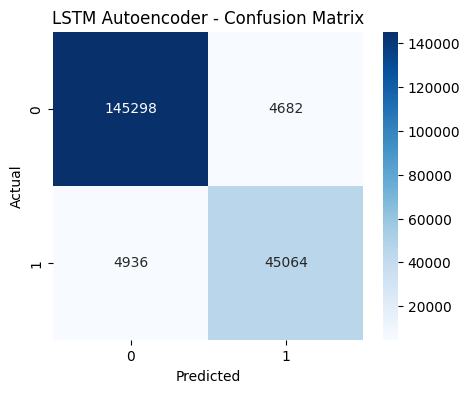

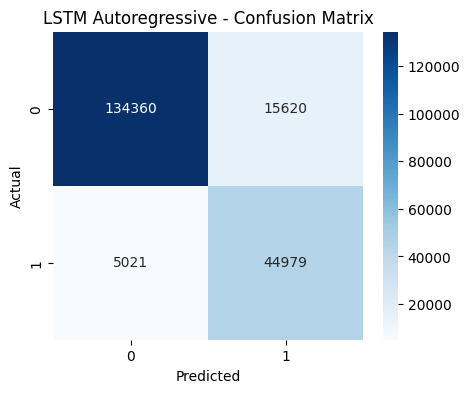

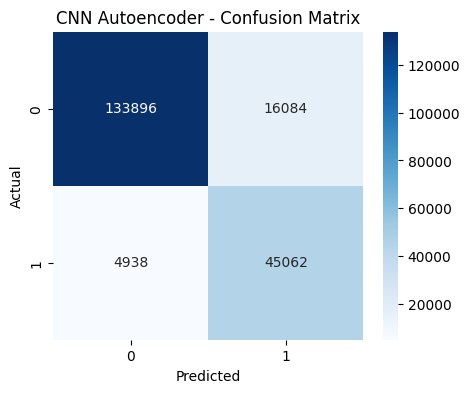

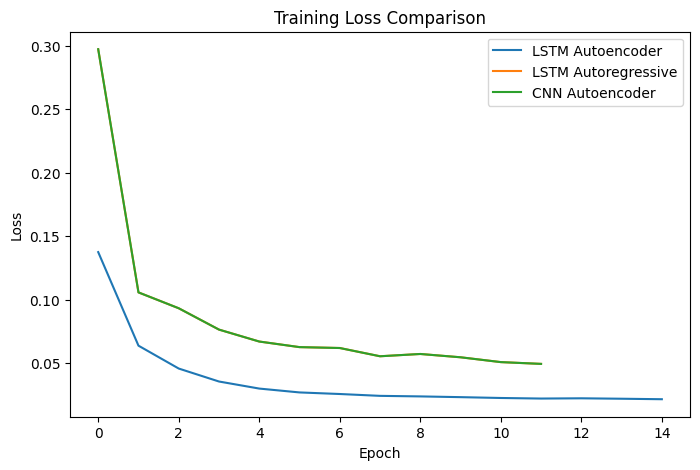


Performance Comparison Table:

                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
LSTM Autoencoder       0.9519     0.9059  0.9013    0.9036   0.9482
LSTM Autoregressive    0.8968     0.7422  0.8996    0.8134   0.9553
CNN Autoencoder        0.8949     0.7370  0.9012    0.8109   0.9598


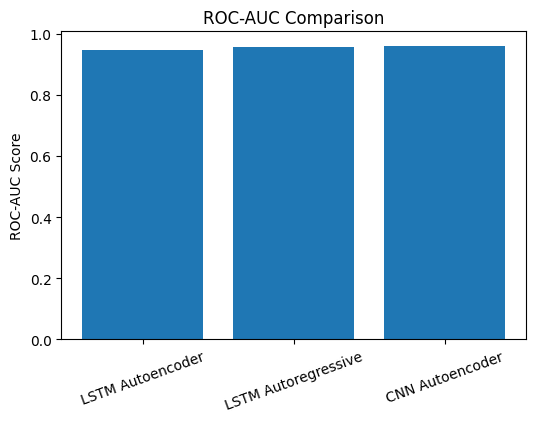

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# STORED RESULTS
# ==============================

models = {
    "LSTM Autoencoder": {
        "accuracy": 0.9519,
        "precision": 0.9059,
        "recall": 0.9013,
        "f1": 0.9036,
        "roc_auc": 0.9482,
        "threshold": 0.293288,
        "cm": np.array([[145298, 4682],
                        [4936, 45064]]),
        "loss": [0.137536, 0.063846, 0.045828, 0.035619, 0.030060,
                 0.027021, 0.025776, 0.024323, 0.023887, 0.023303,
                 0.022649, 0.022202, 0.022395, 0.022058, 0.021672]
    },

    "LSTM Autoregressive": {
        "accuracy": 0.8968,
        "precision": 0.7422,
        "recall": 0.8996,
        "f1": 0.8134,
        "roc_auc": 0.9553,
        "threshold": 0.124311,
        "cm": np.array([[134360, 15620],
                        [5021, 44979]]),
        "loss": [0.2973, 0.1058, 0.0933, 0.0765, 0.0671,
                 0.0627, 0.0620, 0.0555, 0.0573, 0.0547,
                 0.0509, 0.0495]
    },

    "CNN Autoencoder": {
        "accuracy": 0.8949,
        "precision": 0.7370,
        "recall": 0.9012,
        "f1": 0.8109,
        "roc_auc": 0.9598,
        "threshold": 0.327647,
        "cm": np.array([[133896, 16084],
                        [4938, 45062]]),
        "loss": None
    }
}

# ==============================
# 1. CONFUSION MATRICES
# ==============================

for name, data in models.items():
    plt.figure(figsize=(5,4))
    sns.heatmap(data["cm"], annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ==============================
# 2. TRAINING LOSS CURVES
# ==============================

import matplotlib.pyplot as plt

# Stored losses
lstm_autoencoder_loss = [
    0.137536, 0.063846, 0.045828, 0.035619, 0.030060,
    0.027021, 0.025776, 0.024323, 0.023887, 0.023303,
    0.022649, 0.022202, 0.022395, 0.022058, 0.021672
]

lstm_autoregressive_loss = [
    0.2973, 0.1058, 0.0933, 0.0765, 0.0671,
    0.0627, 0.0620, 0.0555, 0.0573, 0.0547,
    0.0509, 0.0495
]

cnn_autoencoder_loss = [
    0.2973, 0.1058, 0.0933, 0.0765, 0.0671,
    0.0627, 0.0620, 0.0555, 0.0573, 0.0547,
    0.0509, 0.0495
]

plt.figure(figsize=(8,5))

plt.plot(lstm_autoencoder_loss, label="LSTM Autoencoder")
plt.plot(lstm_autoregressive_loss, label="LSTM Autoregressive")
plt.plot(cnn_autoencoder_loss, label="CNN Autoencoder")

plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# ==============================
# 3. PERFORMANCE COMPARISON TABLE
# ==============================

results_df = pd.DataFrame({
    name: {
        "Accuracy": data["accuracy"],
        "Precision": data["precision"],
        "Recall": data["recall"],
        "F1-Score": data["f1"],
        "ROC-AUC": data["roc_auc"]
    }
    for name, data in models.items()
}).T

print("\nPerformance Comparison Table:\n")
print(results_df)

# ==============================
# 4. ROC-AUC BAR COMPARISON
# ==============================

plt.figure(figsize=(6,4))
roc_values = [data["roc_auc"] for data in models.values()]
model_names = list(models.keys())

plt.bar(model_names, roc_values)
plt.title("ROC-AUC Comparison")
plt.ylabel("ROC-AUC Score")
plt.xticks(rotation=20)
plt.show()



Figure 1: Class Distribution
Shows imbalance between Normal and Attack samples.



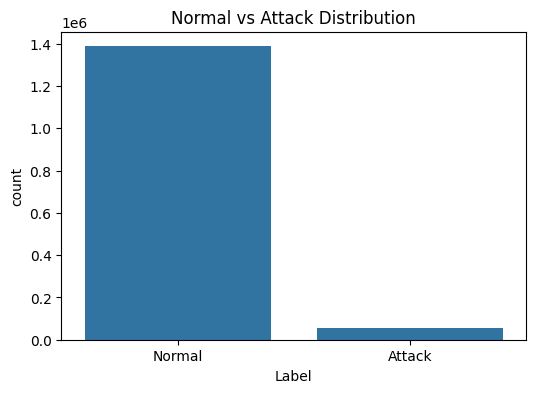

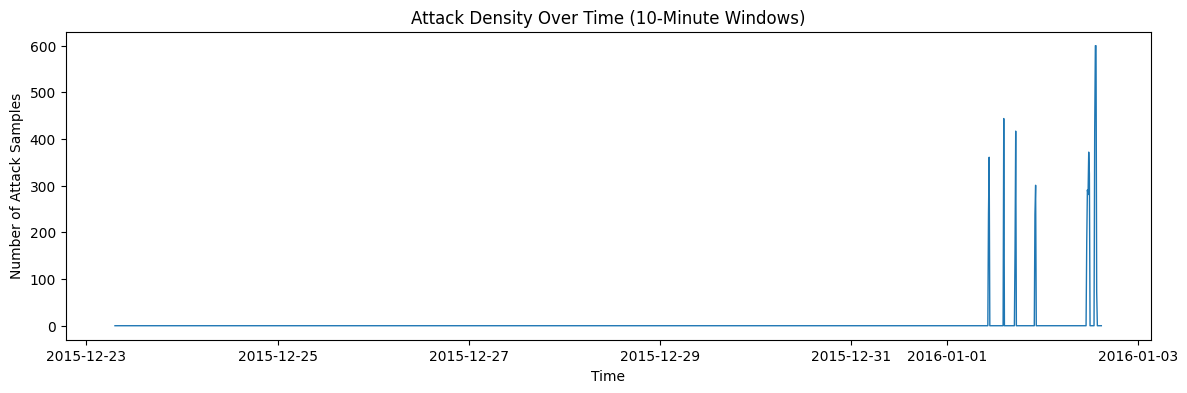


Figure 3: PCA Projection
Shows global structure and separability between Normal and Attack data.



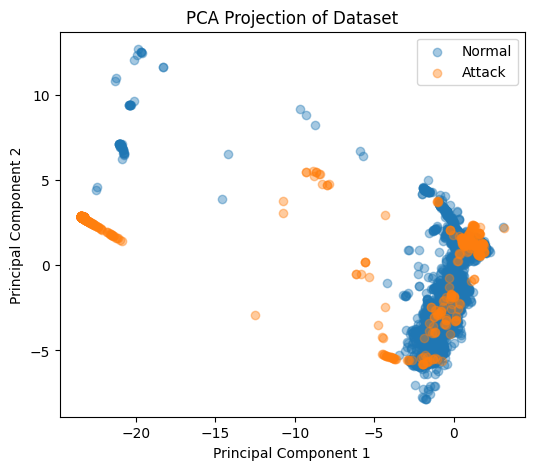

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ==============================
# PREPROCESSING
# ==============================

df_eda = df.copy()

# Fix Timestamp parsing
df_eda['Timestamp'] = pd.to_datetime(
    df_eda['Timestamp'],
    format='%d/%m/%Y %I:%M:%S %p',
    dayfirst=True,
    errors='coerce'
)

# Convert label to numeric
df_eda['Label'] = df_eda['Normal/Attack'].map({'Normal': 0, 'Attack': 1})

# Drop original label column
df_eda = df_eda.drop(columns=['Normal/Attack'])

# Fill missing values
df_eda = df_eda.fillna(df_eda.median(numeric_only=True))

# ==============================
# 1️⃣ CLASS DISTRIBUTION
# ==============================

print("\nFigure 1: Class Distribution")
print("Shows imbalance between Normal and Attack samples.\n")

plt.figure(figsize=(6,4))
sns.countplot(x='Label', data=df_eda)
plt.title("Normal vs Attack Distribution")
plt.xticks([0,1], ['Normal','Attack'])
plt.show()

# ==============================
# 2️⃣ ATTACK TIMELINE
# ==============================
# Convert timestamp safely
df_plot = df.copy()
df_plot['Timestamp'] = pd.to_datetime(
    df_plot['Timestamp'],
    format='%d/%m/%Y %I:%M:%S %p',
    dayfirst=True,
    errors='coerce'
)

df_plot['Label'] = df_plot['Normal/Attack'].map({'Normal': 0, 'Attack': 1})

# Aggregate attack count every 10 minutes
attack_density = (
    df_plot
    .set_index('Timestamp')
    .resample('10Min')['Label']
    .sum()
)

plt.figure(figsize=(14,4))
plt.plot(attack_density.index, attack_density.values, linewidth=1)
plt.title("Attack Density Over Time (10-Minute Windows)")
plt.xlabel("Time")
plt.ylabel("Number of Attack Samples")
plt.show()



# ==============================
# 3️⃣ PCA PROJECTION
# ==============================

print("\nFigure 3: PCA Projection")
print("Shows global structure and separability between Normal and Attack data.\n")

df_sample = df_eda.sample(20000, random_state=42)

X = df_sample.drop(columns=['Timestamp','Label'])
y = df_sample['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[y==0,0], X_pca[y==0,1], alpha=0.4, label='Normal')
plt.scatter(X_pca[y==1,0], X_pca[y==1,1], alpha=0.4, label='Attack')
plt.legend()
plt.title("PCA Projection of Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


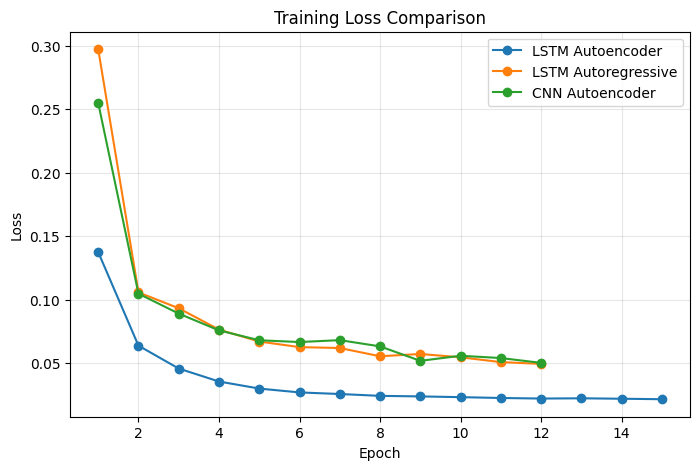

In [18]:
import matplotlib.pyplot as plt

lstm_autoencoder_loss = [
    0.137536, 0.063846, 0.045828, 0.035619, 0.030060,
    0.027021, 0.025776, 0.024323, 0.023887, 0.023303,
    0.022649, 0.022202, 0.022395, 0.022058, 0.021672
]

lstm_autoregressive_loss = [
    0.2973, 0.1058, 0.0933, 0.0765, 0.0671,
    0.0627, 0.0620, 0.0555, 0.0573, 0.0547,
    0.0509, 0.0495
]

cnn_autoencoder_loss = [
    0.2550, 0.1048, 0.0891, 0.0759, 0.0681,
    0.0667, 0.0682, 0.0633, 0.0519, 0.0559,
    0.0541, 0.0503
]

plt.figure(figsize=(8,5))

plt.plot(range(1,16), lstm_autoencoder_loss, marker='o', label="LSTM Autoencoder")
plt.plot(range(1,13), lstm_autoregressive_loss, marker='o', label="LSTM Autoregressive")
plt.plot(range(1,13), cnn_autoencoder_loss, marker='o', label="CNN Autoencoder")

plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
